In [1]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch
from torch import nn
from torchvision.utils import make_grid
import torchvision.models as models
from tqdm.notebook import tqdm
%matplotlib inline

###################
from Archtecture import TrainerBase,AttriGenModel

### Gensim pretrain MODEL
實驗用到的以下Word2Vec:
* 100-d:'glove-twitter-100'--v1  ; glove-wiki-gigaword-100 --v2
* 200-d:'glove-wiki-gigaword-200'
* 300-d:word2vec-google-news-300 ；fasttext-wiki-news-subwords-300

In [2]:
import gensim.downloader
from gensim.models import KeyedVectors
#import fasttext as ft
#from gensim.models import FastText

In [3]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-200')
# glove-wiki-gigaword-200   #'glove-twitter-200'
# glove-wiki-gigaword-100   #glove-twitter-100'
# word2vec-google-news-300  #fasttext-wiki-news-subwords-300  #'glove-wiki-gigaword-300'
# glove-wiki-gigaword-50    #glove-twitter-50

# Setting

In [4]:
out_dim = 200  # WordVector的Output_dimension
#resnet_path = ".\model\my_RES_ag_2.pth"
RetrainedResNet = False
IsShuffle = True

'''
IsShuffle: DataLoader決定要不要打亂，由於Training只有讓Encoder出來的值與Word Vector作loss比較，因此打亂的話label會沒有對應
測試分類的時候，不採用打亂。所以要設定False。
'''

batch_size = 64
opt_func = torch.optim.Adam
lr = 3e-3


dataset = 'AWA2'
########################################
train_path = Path("./data/{}/IMG_backoff/train".format(dataset))
test_path = Path("./data/{}/IMG_backoff/test".format(dataset))
val_path = Path("./data/{}/IMG_backoff/val".format(dataset))

'''儲存path在Train_Data處理時候才定義。 格式: './{}_{}c/data_{}/'.format(dataset, len(train_classes),out_dim)'''
if dataset == 'AWA2':
    class_num = 33   #Train的Class數。
    load_path = './{}_{}c/data_{}/'.format(dataset,class_num,out_dim)
    model_path ='./model/{}/'.format(dataset)
    test_img ='./test_img/'
#elseif:

In [5]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [6]:
device = get_default_device()
model = to_device(AttriGenModel(out_dim), device)

## Evaluation & Predict

### Model Load:

In [7]:
model_path=Path(model_path+"test.pth")
model.load_state_dict(torch.load(model_path))
#model = torch.load(model_path)
optimizer = opt_func(model.parameters(), lr)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Data

In [8]:
train_classes = []
train_images = []
train_img_vecs = []
train_class_labels=[]

val_classes = []
val_images = []
val_img_vecs = []
val_class_labels=[]

test_classes=[]
test_images = []
test_img_vecs = []
test_class_labels=[]

In [9]:
train_images=np.load(load_path+'train_img_name.npy',allow_pickle=True)
train_img_vecs=np.load(load_path+'train_img_vec.npy',allow_pickle=True)
train_classes=np.load(load_path+'train_class.npy',allow_pickle=True)
train_class_labels=np.load(load_path+'train_img_label.npy',allow_pickle=True)

val_images=np.load(load_path+'val_img_name.npy',allow_pickle=True)
val_img_vecs=np.load(load_path+'val_img_vec.npy',allow_pickle=True)
val_classes=np.load(load_path+'val_class.npy',allow_pickle=True)
val_class_labels=np.load(load_path+'val_img_label.npy',allow_pickle=True)

test_images=np.load(load_path+'test_img_name.npy',allow_pickle=True)
test_img_vecs=np.load(load_path+'test_img_vec.npy',allow_pickle=True)
test_classes=np.load(load_path+'test_class.npy',allow_pickle=True)
test_class_labels=np.load(load_path+'test_img_label.npy',allow_pickle=True)

In [10]:
class Dataset(Dataset):
    #def __init__(self, images, vecs,labels, transform=None):#(self, images, vecs,labels, transform=None):
    def __init__(self, images, vecs, transform=None):
        self.images = images
        self.vecs = vecs
        self.transform = transform
        #self.labels=labels
    def __len__(self):
        return len(self.images)    
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        img_vec = self.vecs[idx]
        #label = self.labels[idx]
        #img_class = self.labels[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, img_vec #,label

In [11]:
transform  = transforms.Compose([transforms.Resize(size=(200,200)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

train_dataset = Dataset(train_images,train_img_vecs,transform)
val_dataset = Dataset(val_images,val_img_vecs,transform)
test_dataset = Dataset(test_images,test_img_vecs,transform)

In [12]:
train_dl = DataLoader(train_dataset, batch_size, shuffle=False,
                      drop_last=False, num_workers=0, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size, shuffle=False,
                    drop_last=False, num_workers=0, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size, shuffle=False,
                     drop_last=False, num_workers=0, pin_memory=True)

In [13]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

### Attribute func.

In [14]:
def predict_dl_batch(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    model.eval()
    for xb, _ in tqdm(dl):
        pred_wv = model(xb.cuda())
        batch_probs.append(pred_wv.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return batch_probs.numpy()

In [15]:
def Attribute_Transform(Type, dl):  # (將圖片2048轉成WordVector)
    try:
        pred = np.load(load_path+'{}_attr.npy'.format(Type), allow_pickle=True)
    except IOError:
        pred = predict_dl_batch(dl, model)
        np.save(load_path+'{}_attr.npy'.format(Type), pred)
    return pred

#### Val_attribute

In [16]:
pred_val=[]
pred_val = Attribute_Transform('val',val_dl)

In [17]:
print(pred_val.shape)

(5268, 200)


In [19]:
#print(pred_val[0])
#dataset[0](第幾張圖)[0](img的RGB)，dataset[0](第幾張圖)[1](img的word Vec)
#print((val_dataset[0][0]))
#print((val_dataset[0][1]))
#print((val_img_vecs[0]))

In [20]:
'''
import math
sum=0
for k in range(len(val_img_vecs[0])):
    sum=sum+pow(pred_val[3][k]-val_img_vecs[3][k],2)
print(math.sqrt(sum))
'''

'\nimport math\nsum=0\nfor k in range(len(val_img_vecs[0])):\n    sum=sum+pow(pred_val[3][k]-val_img_vecs[3][k],2)\nprint(math.sqrt(sum))\n'

#### Train_attribute

In [21]:
pred_train = []
pred_train = Attribute_Transform('train',train_dl)

In [22]:
print(pred_train.shape)

(21057, 200)


In [24]:
'''
for m in range(33):
    sum=0
    for k in range(len(train_img_vecs[m])):
        sum=sum+pow(pred_train[m][k]-train_img_vecs[m][k],2)
    print(math.sqrt(sum))
'''

'\nfor m in range(33):\n    sum=0\n    for k in range(len(train_img_vecs[m])):\n        sum=sum+pow(pred_train[m][k]-train_img_vecs[m][k],2)\n    print(math.sqrt(sum))\n'

#### Test Attribute

In [25]:
pred_test = Attribute_Transform('test',test_dl)

  0%|          | 0/73 [00:00<?, ?it/s]

In [26]:
print(pred_test.shape)

(4654, 200)


## 實驗:img與Word Vector轉換

In [28]:
import nmslib     #類似於KNN作法，Gensim中推薦測試使用的， 可google搜尋"nmslib"

def create_index(a):
    index = nmslib.init(space='angulardist')
    index.addDataPointBatch(a)
    index.createIndex()
    return index

def get_knns(index, vecs):
     return zip(*index.knnQueryBatch(vecs, k=1, num_threads=4))

def get_knn(index, vec): return index.knnQuery(vec, k=25)

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


### show圖

In [29]:
def denorm(img,mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    return img*torch.Tensor(std).unsqueeze(1).unsqueeze(1)+torch.Tensor(mean).unsqueeze(1).unsqueeze(1)
def show_sample(img, target, invert=True):
    img = denorm(img).clamp(0,1)
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))

In [30]:
def show_preds(idxs,dset="valid"):
    if dset == "valid":
        dataset = val_dataset
        images = val_images
    elif dset == "test":
        dataset = test_dataset
        images = test_images
    elif dset == "mix":
        dataset = datasets
        images = Images
    elif dset == "train":
        dataset=train_dataset
        images=train_images
        
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8,8))
    for ax,img_idx in zip(axes.flatten(),idxs[:25]):
        p=Path(images[img_idx])
        data = denorm(dataset[img_idx][0]).clamp(0,1)
        data = data.permute(1,2,0).numpy()
        ax.imshow(data)
        title = p.parent.name.rpartition(".")[-1]   ###可抓到label !!!!
        ax.set_title(title)
        ax.axis("off")
    return images[idxs[0]].parent.name.rpartition(".")[-1]

### Seen(Val_data)

In [31]:
nn_predwv = create_index(pred_val)

[0.8240587  0.82410574 0.8317651  0.839513   0.8396348  0.8445449
 0.84678566 0.8545417  0.8592917  0.86024785 0.8620649  0.86419356
 0.8668067  0.87177694 0.87338793 0.8750518  0.8760869  0.87706167
 0.8771206  0.8812145  0.88184065 0.8831216  0.88538253 0.8879024
 0.890248  ]


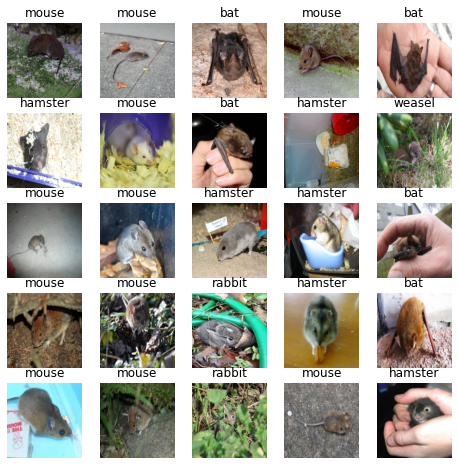

In [32]:
#給"Word"，轉成WordVector後從model中的資料找最相關。
vec =glove_vectors.get_vector('mouse')
idxs,dists = get_knn(nn_predwv, vec)
name = show_preds(idxs)
print(dists)

## Image reverse search

#### 輸入圖片，給top5個Word

In [33]:
def ReverseSearch(path):
    img=Image.open(path)
    plt.imshow(img)
    img=img.resize(size=(200,200))
    pred_img=model(transform(img).unsqueeze(0).cuda())
    idxs,dists = get_knn(nn_predwv, pred_img.cpu().detach().numpy())
    return show_preds(idxs)

tiger


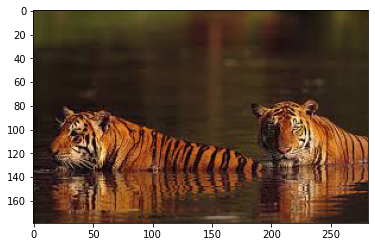

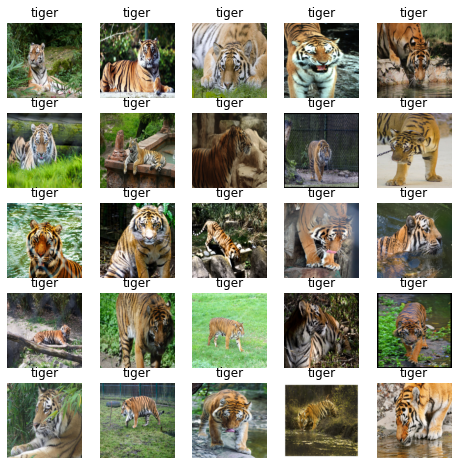

In [34]:
names=ReverseSearch(test_img+"tiger4.jpg")
print(names)

In [35]:
glove_vectors.most_similar(names,topn=5)

[('tigers', 0.6394124627113342),
 ('woods', 0.5961560606956482),
 ('mickelson', 0.5454031229019165),
 ('elephant', 0.5280882120132446),
 ('tamil', 0.5262120962142944)]

gorilla


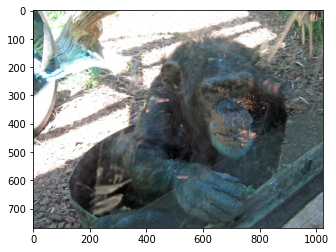

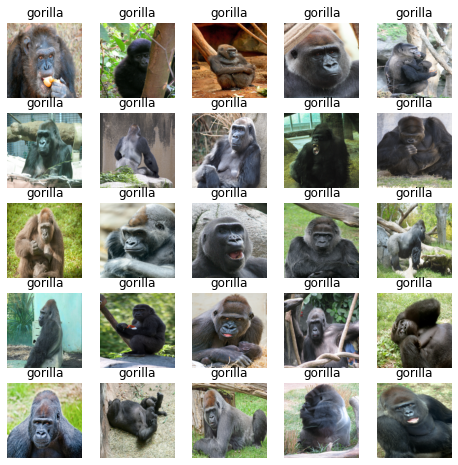

In [36]:
names=ReverseSearch(test_img+"./chimpanzee_10003.jpg")
print(names)

In [37]:
l=[]
l=glove_vectors.most_similar(names,topn=5)
recommend= []
recommend.append(glove_vectors.most_similar(l[0][0],topn=5))

In [38]:
recommend

[[('900-pound', 0.675678551197052),
  ('gorilla', 0.6485722661018372),
  ('600-pound', 0.5116898417472839),
  ('400-pound', 0.5073153376579285),
  ('gorillas', 0.4912770092487335)]]

hamster


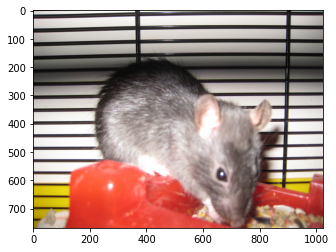

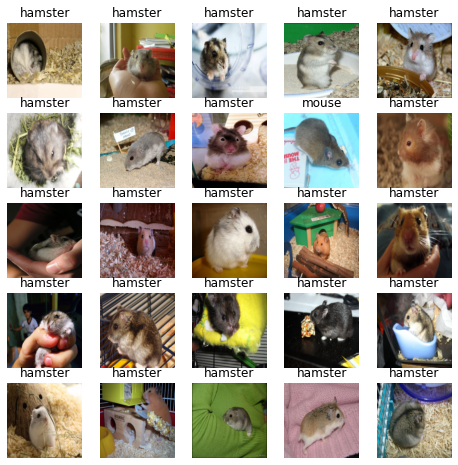

In [39]:
names=ReverseSearch(test_img+"./rat.jpg")
print(names)

In [40]:
l=[]
l=glove_vectors.most_similar(names,topn=5)
recommend= []
recommend.append(glove_vectors.most_similar(l[0][0],topn=5))

In [41]:
recommend

[[('gerbils', 0.7242090106010437),
  ('hamster', 0.5704230070114136),
  ('rabbits', 0.5671870708465576),
  ('chinchillas', 0.5570951104164124),
  ('ferrets', 0.5347434878349304)]]

bobcat


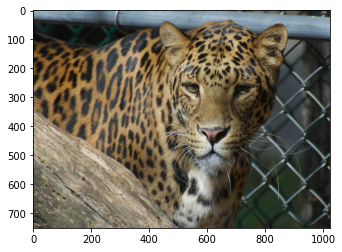

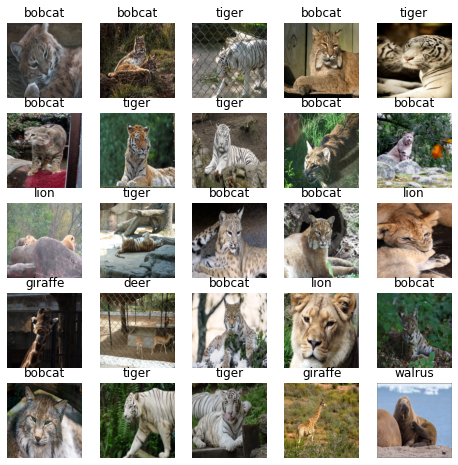

In [42]:
names=ReverseSearch(test_img+"./leopard_10001.jpg")
print(names)

In [43]:
l=[]
l=glove_vectors.most_similar(names,topn=5)
recommend= []
recommend.append(glove_vectors.most_similar(l[0][0],topn=5))

In [44]:
recommend

[[('bobcat', 0.5789192318916321),
  ('saget', 0.42118149995803833),
  ('smither', 0.40817543864250183),
  ('bogosian', 0.40801697969436646),
  ('sturken', 0.3985797166824341)]]

rhinoceros


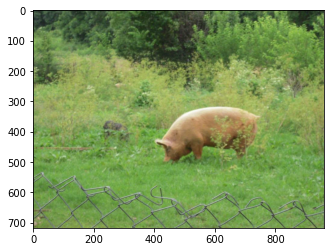

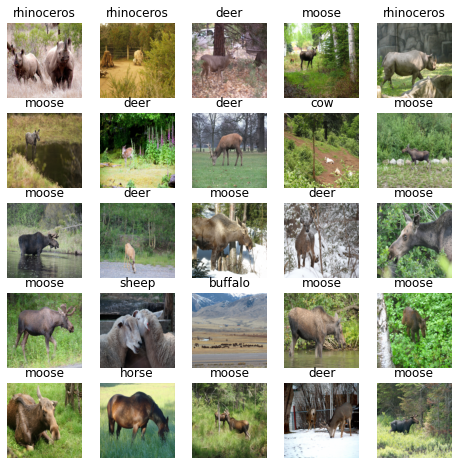

In [45]:
names=ReverseSearch(test_img+"./pig_10012.jpg")
print(names)

In [46]:
l=[]
l=glove_vectors.most_similar(names,topn=5)
recommend= []
recommend.append(glove_vectors.most_similar(l[0][0],topn=5))

In [47]:
recommend

[[('elephants', 0.7349486351013184),
  ('rhinoceros', 0.6177135705947876),
  ('rhino', 0.604858934879303),
  ('lion', 0.5981978178024292),
  ('tusks', 0.5563178658485413)]]

ox


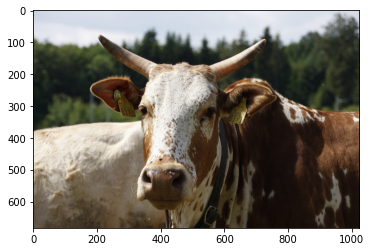

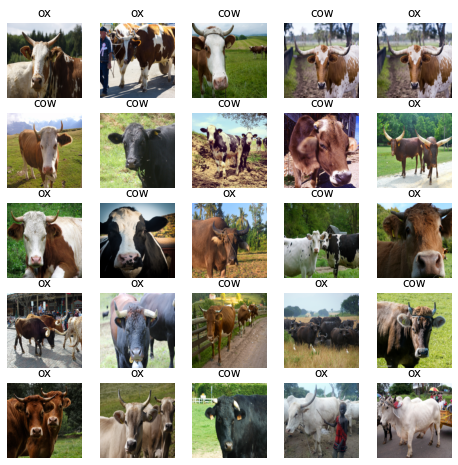

In [48]:
names=ReverseSearch(test_img+"./ox_10043.jpg")
print(names)

In [49]:
l=[]
l=glove_vectors.most_similar(names,topn=5)
recommend= []
recommend.append(glove_vectors.most_similar(l[0][0],topn=5))

In [50]:
recommend

[[('donkeys', 0.6502612233161926),
  ('ox', 0.641258180141449),
  ('mules', 0.6090449094772339),
  ('camels', 0.6006430387496948),
  ('horses', 0.5487847924232483)]]

## Test data eval

In [51]:
print(test_classes)

['hippopotamus' 'pig' 'leopard' 'seal' 'chimpanzee' 'rat' 'raccoon']


In [52]:
test_nn_predwv = create_index(pred_test)

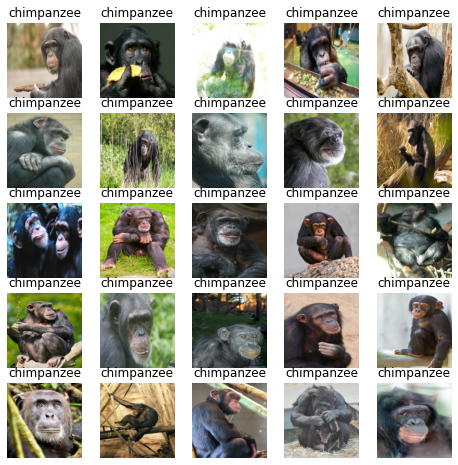

In [53]:
#vec = ft_model.wv['bear']
vec = glove_vectors.get_vector('chimpanzee')
idxs,dists = get_knn(test_nn_predwv, vec)
names=show_preds(idxs,dset="test")

In [54]:
l=[]
l=glove_vectors.most_similar(names,topn=5)
recommend= []
recommend.append(glove_vectors.most_similar(l[0][0],topn=5))
recommend

[[('chimpanzee', 0.7751609683036804),
  ('chimps', 0.5476611852645874),
  ('chimpanzees', 0.5234293937683105),
  ('bonobo', 0.47701913118362427),
  ('gorilla', 0.4635811448097229)]]

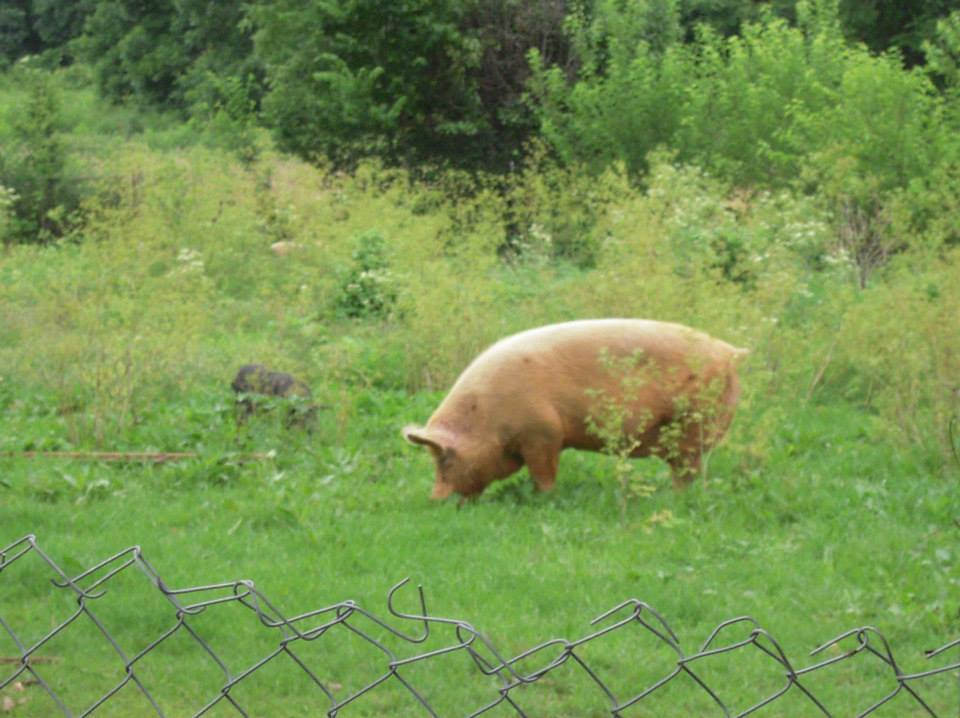

In [55]:
img=Image.open(test_img+"./pig_10012.jpg")
img

'pig'

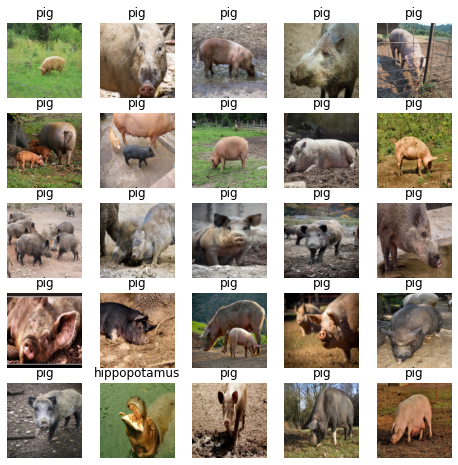

In [56]:
img=img.resize(size=(200,200))
pred_img=model(transform(img).unsqueeze(0).cuda())
idxs,dists = get_knn(test_nn_predwv, pred_img.cpu().detach().numpy())
names=show_preds(idxs,dset="test")
names